In [1]:
from tensorflow.keras.layers import Conv2D,Flatten,Dense,MaxPool2D,BatchNormalization,GlobalAveragePooling2D
from tensorflow.keras.applications.resnet50 import preprocess_input, decode_predictions
from tensorflow.keras.preprocessing.image import ImageDataGenerator,load_img
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Sequential
from tensorflow.keras.models import Model
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import numpy as np
from keras import applications

In [2]:
img_height, img_width = (224,224)
batch_size = 16

train_data_dir = r"./DataSplit/train"
valid_data_dir = r"./DataSplit/val"
test_data_dir = r"./DataSplit/test"

In [3]:
train_datagen = ImageDataGenerator(preprocessing_function = preprocess_input,
                                  shear_range = 0.2,
                                  zoom_range = 0.2,
                                  validation_split = 0.2,
                                  horizontal_flip=True,)

train_generator = train_datagen.flow_from_directory(train_data_dir,
                                                   target_size = (img_height,img_width),
                                                   batch_size = batch_size,
                                                   class_mode = 'categorical',
                                                   subset = 'training')

valid_generator = train_datagen.flow_from_directory(valid_data_dir,
                                                   target_size = (img_height,img_width),
                                                   batch_size = batch_size,
                                                   class_mode = 'categorical',
                                                   subset = 'validation')

Found 219 images belonging to 4 classes.
Found 18 images belonging to 4 classes.


In [4]:
test_generator = train_datagen.flow_from_directory(test_data_dir,
                                                  target_size = (img_height,img_width),
                                                  batch_size = 1,
                                                  class_mode = 'categorical',)

Found 92 images belonging to 4 classes.


In [5]:
x,y = test_generator.next()
x.shape

print(train_generator.num_classes)

4


In [6]:
base_model = applications.densenet.DenseNet201(include_top=False, weights = 'imagenet')
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024,activation = 'relu')(x)
predictions = Dense(train_generator.num_classes, activation='softmax')(x)
model = Model(inputs=base_model.input,outputs=predictions)

for layer in base_model.layers:
    layer.trainable = False
    
model.compile(optimizer = 'adam', loss = 'categorical_crossentropy',metrics = ['accuracy'])

obj = model.fit(train_generator,validation_data=valid_generator, epochs = 5)

2022-03-14 11:16:55.595824: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


74850304/74836368 [==============================] - 20s 0us/step


2022-03-14 11:17:21.450460: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/5
14/14 [==============================] - 41s 2s/step - loss: 6.8982 - accuracy: 0.4977 - val_loss: 0.8348 - val_accuracy: 0.8889
Epoch 2/5
14/14 [==============================] - 32s 2s/step - loss: 1.2394 - accuracy: 0.7671 - val_loss: 0.5185 - val_accuracy: 0.8333
Epoch 3/5
14/14 [==============================] - 33s 2s/step - loss: 0.9837 - accuracy: 0.8128 - val_loss: 0.8413 - val_accuracy: 0.7778
Epoch 4/5
14/14 [==============================] - 34s 2s/step - loss: 0.5262 - accuracy: 0.9087 - val_loss: 1.3199 - val_accuracy: 0.7222
Epoch 5/5
14/14 [==============================] - 34s 2s/step - loss: 0.6858 - accuracy: 0.8995 - val_loss: 0.2331 - val_accuracy: 0.9444


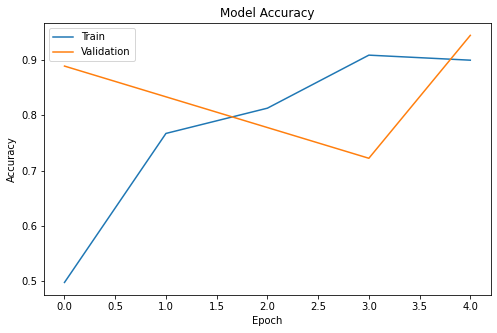

In [7]:
plt.figure(figsize=(8,5))

plt.plot(obj.history['accuracy'])
plt.plot(obj.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.gca().ticklabel_format(axis='both', style='plain', useOffset=False)
plt.show()

In [8]:
model.save(r"./Models/DenseNet.h5")

In [9]:
test_loss, test_acc = model.evaluate(test_generator, verbose=2)

print("\nTest accuracy: ",test_acc)

92/92 - 16s - loss: 0.4963 - accuracy: 0.9130

Test accuracy:  0.9130434989929199


2022-03-14 23:00:22.299889: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-03-14 23:00:26.744535: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


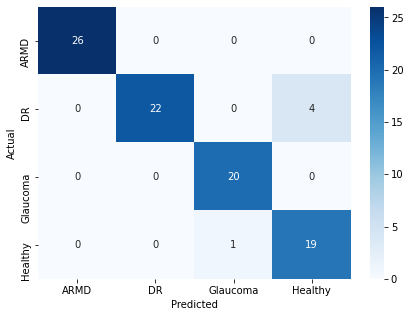

In [5]:
import pandas as pd
import seaborn as sn
import tensorflow as tf

model = tf.keras.models.load_model(r"./Models/DenseNet.h5")
filenames = test_generator.filenames

# print(filenames)

nb_samples = len(test_generator)
y_prob = []
y_act = []
figure(figsize=(7, 5))
test_generator.reset()
for _ in range(nb_samples):
    X_test,Y_test = test_generator.next()
    y_prob.append(model.predict(X_test))
    y_act.append(Y_test)
    
predicted_class = [list(train_generator.class_indices.keys())[i.argmax()] for i in y_prob]
actual_class = [list(train_generator.class_indices.keys())[i.argmax()] for i in y_act]

# print(predicted_class)


out_df = pd.DataFrame(np.vstack([predicted_class,actual_class]).T,columns=['predicted_class','actual_class'])
confusion_matrix = pd.crosstab(out_df['actual_class'],out_df['predicted_class'],rownames=['Actual'],colnames=['Predicted'])

sn.heatmap(confusion_matrix,cmap='Blues',annot=True, fmt='d' )

plt.show()
# print("test accuracy : {}".format((np.diagonal(confusion_matrix).sum()/confusion_matrix.sum()*100)))

In [6]:
correctPredictions = {'ARMD' : confusion_matrix['ARMD']['ARMD'], 'DR' : confusion_matrix['DR']['DR'], 'Glaucoma' : confusion_matrix['Glaucoma']['Glaucoma'], 'Healthy' : confusion_matrix['Healthy']['Healthy']}

deNames = ['ARMD','DR','Glaucoma','Healthy']
totalCases = {'ARMD' : 0,'DR' : 0,'Glaucoma': 0,'Healthy': 0}
for name in deNames:
    for i in range(0,len(confusion_matrix[name])):
        if(i == 0):
            totalCases['ARMD'] += confusion_matrix[name][i]
        elif(i == 1):
            totalCases['DR'] += confusion_matrix[name][i]
        elif(i == 2):
            totalCases['Glaucoma'] += confusion_matrix[name][i]
        else:
            totalCases['Healthy'] += confusion_matrix[name][i]
# print(totalCases)

print("Test Accuracies : \n")
print("ARMD      :",correctPredictions['ARMD']/totalCases['ARMD'])
print("DR        :",correctPredictions['DR']/totalCases['DR'])
print("Glaucoma  :",correctPredictions['Glaucoma']/totalCases['Glaucoma'])
print("Healthy   :",correctPredictions['Healthy']/totalCases['Healthy'])

Test Accuracies : 

ARMD      : 1.0
DR        : 0.8461538461538461
Glaucoma  : 1.0
Healthy   : 0.95
